In [1]:
import os
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x


num_epochs = 100
batch_size = 128
learning_rate = 1e-3

img_transform = transforms.Compose([
    transforms.ToTensor()])

# dataset = MNIST('./data', transform=img_transform, download=True)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# load the training and test datasets
train_data = MNIST(root='./data', train=True,
                                   download=True, transform=img_transform)
test_data = MNIST(root='./data', train=False,
                                  download=True, transform=img_transform)

# dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(train_data, batch_size=2000, shuffle=True)

In [21]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, 2))
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [36]:
model = autoencoder().cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [37]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1).cuda()
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img/image_{}.png'.format(epoch))
torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.2288
epoch [2/100], loss:0.2166
epoch [3/100], loss:0.2090
epoch [4/100], loss:0.2070
epoch [5/100], loss:0.1936
epoch [6/100], loss:0.1901
epoch [7/100], loss:0.2064
epoch [8/100], loss:0.1835
epoch [9/100], loss:0.1980
epoch [10/100], loss:0.1800
epoch [11/100], loss:0.1820
epoch [12/100], loss:0.1928
epoch [13/100], loss:0.1776
epoch [14/100], loss:0.1834
epoch [15/100], loss:0.1973
epoch [16/100], loss:0.1879
epoch [17/100], loss:0.1722
epoch [18/100], loss:0.1908
epoch [19/100], loss:0.1809
epoch [20/100], loss:0.1794
epoch [21/100], loss:0.1851
epoch [22/100], loss:0.1863
epoch [23/100], loss:0.1750
epoch [24/100], loss:0.1788
epoch [25/100], loss:0.1837
epoch [26/100], loss:0.1814
epoch [27/100], loss:0.1753
epoch [28/100], loss:0.1776
epoch [29/100], loss:0.1806
epoch [30/100], loss:0.1734
epoch [31/100], loss:0.1856
epoch [32/100], loss:0.1845
epoch [33/100], loss:0.1774
epoch [34/100], loss:0.1780
epoch [35/100], loss:0.1617
epoch [36/100], loss:0.1752
e

torch.Size([60000, 1, 28, 28])


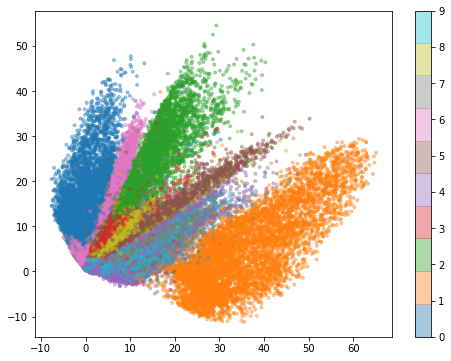

In [24]:
x_test=[]
y_test=[]
ct = 0
for d in testloader:
    x,y = d 
    x_test.append(x)
    y_test.append(y)
    ct += 1
    if ct>100:
        break
x_test = torch.cat(x_test, dim=0)
print(x_test.size())
y_test = torch.cat(y_test, dim=0)
x_test = x_test.view(x_test.size(0), -1)
# display a 2D plot of the digit classes in the latent space
with torch.no_grad():
    z_test1 = model.encoder(x_test.to(device))
z_test1 = z_test1.cpu()
plt.figure(figsize=(8,6))
plt.scatter(z_test1[:, 0], z_test1[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='tab10')
plt.colorbar()
plt.show()

(20, 20, 2)
torch.Size([400, 2])


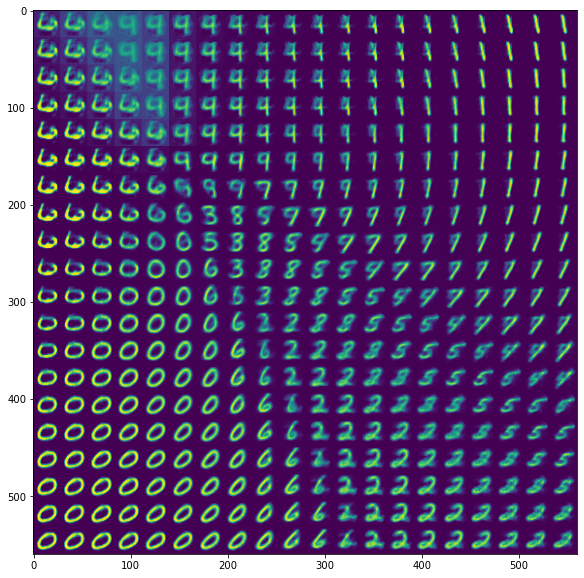

In [25]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
latent_dim = 2


z1 = np.linspace(-10, 30., n)
z2 = np.linspace(-10, 30, n)
z_grid = np.dstack(np.meshgrid(z1, z2))

print(z_grid.shape)

z_grid = torch.from_numpy(z_grid.reshape(n*n, latent_dim)).float().to(device)
print(z_grid.size())


x_pred_grid  = model.decoder(z_grid) 

x_pred_grid = x_pred_grid.cpu().detach().numpy().reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='viridis')
plt.show()

In [3]:
class Cons_lin_layer(nn.Module):
    def __init__(self, n_in, n_out, nonlin = 'tanh', p = 2):
        super(Cons_lin_layer,self).__init__()
        self.lin = nn.Linear(n_in,n_out)
        if nonlin == 'none':
            self.layer = self.lin
        else:
            if nonlin == 'tanh':
                self.nonlin = nn.Tanh()
            elif nonlin == 'relu':
                self.nonlin = nn.ReLU()
            elif nonlin == 'sigmoid':
                self.nonlin = nn.Sigmoid()
            self.layer = nn.Sequential(self.lin,self.nonlin)
       
        self.p = p
   
    def forward(self, x):
        energy = x.norm(p=self.p, dim=-1, keepdim=True)
        y = self.layer(x)
        y = F.normalize(y,p=self.p,dim=-1)*energy
        return y

In [4]:
class c_autoencoder(nn.Module):
    def __init__(self):
        super(c_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            Cons_lin_layer(28*28,128, nonlin='relu'),
            Cons_lin_layer(128,64, nonlin='relu'),
            Cons_lin_layer(64,12, nonlin='relu'),
            Cons_lin_layer(12,2, nonlin='none'))
        
        self.decoder = nn.Sequential(
            Cons_lin_layer(2,12, nonlin='relu'),
            Cons_lin_layer(12,64, nonlin='relu'),
            Cons_lin_layer(64,128, nonlin='relu'),
            Cons_lin_layer(128,28*28, nonlin='sigmoid'))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
cmodel = c_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    cmodel.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1).cuda()
        # ===================forward=====================
        output = cmodel(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, './mlp_img_c/image_{}.png'.format(epoch))
torch.save(model.state_dict(), './c_sim_autoencoder.pth')

epoch [1/100], loss:0.0558
epoch [2/100], loss:0.0532
epoch [3/100], loss:0.0565
epoch [4/100], loss:0.0502
epoch [5/100], loss:0.0578
epoch [6/100], loss:0.0496
epoch [7/100], loss:0.0488
epoch [8/100], loss:0.0508
epoch [9/100], loss:0.0484
epoch [10/100], loss:0.0532
epoch [11/100], loss:0.0515
epoch [12/100], loss:0.0546
epoch [13/100], loss:0.0502
epoch [14/100], loss:0.0550
epoch [15/100], loss:0.0464
epoch [16/100], loss:0.0500
epoch [17/100], loss:0.0461
epoch [18/100], loss:0.0517
epoch [19/100], loss:0.0522
epoch [20/100], loss:0.0482
epoch [21/100], loss:0.0476
epoch [22/100], loss:0.0460
epoch [23/100], loss:0.0520
epoch [24/100], loss:0.0507
epoch [25/100], loss:0.0548
epoch [26/100], loss:0.0663
epoch [27/100], loss:0.0511
epoch [28/100], loss:0.0500
epoch [29/100], loss:0.0489
epoch [30/100], loss:0.0483
epoch [31/100], loss:0.0545
epoch [32/100], loss:0.0486
epoch [33/100], loss:0.0547
epoch [34/100], loss:0.0521
epoch [35/100], loss:0.0553
epoch [36/100], loss:0.0498
e

torch.Size([60000, 1, 28, 28])


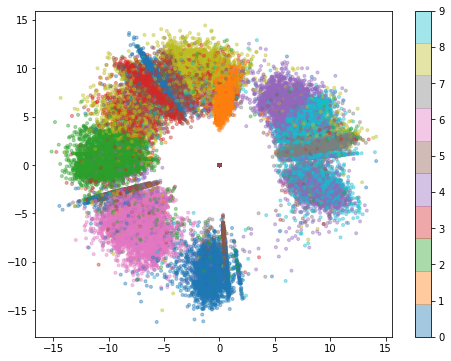

In [34]:
x_test=[]
y_test=[]
ct = 0
for d in testloader:
    x,y = d 
    x_test.append(x)
    y_test.append(y)
    ct += 1
    if ct>100:
        break
x_test = torch.cat(x_test, dim=0)
print(x_test.size())
y_test = torch.cat(y_test, dim=0)
x_test = x_test.view(x_test.size(0), -1)
# display a 2D plot of the digit classes in the latent space
with torch.no_grad():
    z_test1 = cmodel.encoder(x_test.to(device))
z_test1 = z_test1.cpu()
plt.figure(figsize=(8,6))
plt.scatter(z_test1[:, 0], z_test1[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='tab10')
plt.colorbar()
plt.show()

(20, 20, 2)
torch.Size([400, 2])


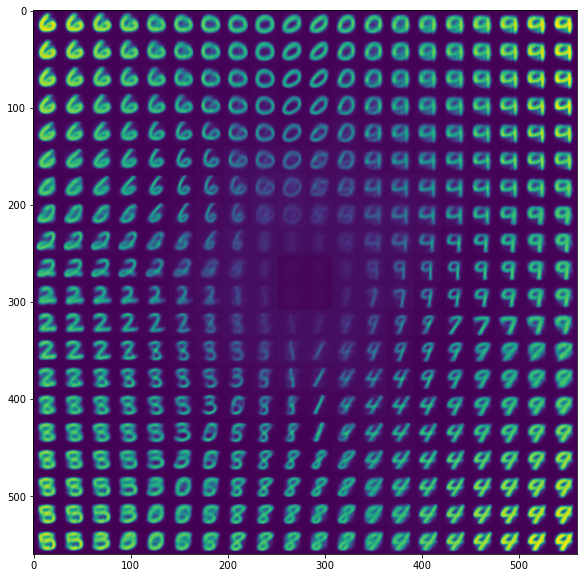

In [35]:
# display a 2D manifold of the digits
n = 20  # figure with 15x15 digits
digit_size = 28
latent_dim = 2


z1 = np.linspace(-15, 15., n)
z2 = np.linspace(-15, 15, n)
z_grid = np.dstack(np.meshgrid(z1, z2))

print(z_grid.shape)

z_grid = torch.from_numpy(z_grid.reshape(n*n, latent_dim)).float().to(device)
print(z_grid.size())


x_pred_grid  = cmodel.decoder(z_grid) 

x_pred_grid = x_pred_grid.cpu().detach().numpy().reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='viridis')
plt.show()